In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Dropout, Dense, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l1, l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, bernoulli
from bitstring import BitArray
from math import sqrt
from deap import base, creator, tools, algorithms

In [2]:
df = pd.read_csv("Airpollution_final_v3.csv")
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df = df.set_index(['date'], drop=True)

In [3]:
#Converts dataframe to array
data = df.to_numpy()

#Split into training and test data
data_length = len(data)
train_split = 0.9
train_length = int(train_split * data_length)
test_length = data_length - train_length

x_train = data[0:train_length, :]
x_test = data[train_length:, :]

y_train = data[0:train_length, -1]
y_test = data[train_length:, -1]

In [4]:
#Normalises the data
x_scaler = MinMaxScaler((0,1))
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler((0,1))
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = y_scaler.transform(y_test.reshape(-1,1))

[1, 2, 3, 4, 5]
(62073, 8)


In [5]:
def GetLabels(sequence, n_steps, window_space=1):
#Finds the labels for the data and returns the sequence
    label_seq = []
    for i in range(0, len(sequence), window_space):
        end_index = i + n_steps
        if end_index > len(sequence)-1:
            break
        labels = sequence[end_index]
        label_seq.append(labels)
    
    label_seq = np.array(label_seq)
    label_seq = label_seq.reshape(len(label_seq),1)
    
    return label_seq

In [6]:
def split_sequence(sequence, n_steps, window_space=1):
#Wdinows the data for each column
    for j in range(sequence.shape[1]):
        
        data_seq = []
        for i in range(0, len(sequence[:, j]), window_space):
            end_index = i + n_steps
            if end_index > sequence.shape[0]-1:
                break
            x = sequence[i:end_index, j]
            data_seq.append(x) 
            
        data_seq = np.array(data_seq)
        data_seq = np.expand_dims(data_seq, axis=2)
    
        if j == 0:
            data = data_seq
        else:
            data = np.concatenate((data, data_seq), axis=2)    
            
    return (data)

In [7]:
def prepareDataset(window_size, window_space):
    #Extract train and test features
    train_features = split_sequence(x_train_scaled, window_size, window_space)
    test_features = split_sequence(x_test_scaled, window_size, window_space)
    train_input, test_input = train_features.reshape((train_features.shape[0], int(sqrt(window_size)), int(sqrt(window_size)), train_features.shape[2])), test_features.reshape((test_features.shape[0], int(sqrt(window_size)), int(sqrt(window_size)), test_features.shape[2]))

    #Get train and test labels
    train_labels = GetLabels(y_train_scaled, window_size, window_space)
    test_labels = GetLabels(y_test_scaled, window_size, window_space)
    
    return train_input, test_input, train_labels, test_labels

In [8]:
def mse(y_true, y_pred):
#Loss function
    loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_true, predictions=y_pred))
    return loss

In [9]:
def plotperformance(history):
#Plots the loss and MAE graphs   
    plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    
    plt.figure(figsize=(7,5))
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('model train vs validation mean absolute error')
    plt.ylabel('mean absolute error')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()
    

In [10]:
def plotpredictions(model, y_pred, y_labels):
# Plots the prdictions of the test data
    y_pred = model.predict(y_pred)
    y_pred = np.average(y_pred, axis=1)
    y_pred_rescaled = y_scaler.inverse_transform(y_pred) 
    y_labels_rescaled = y_scaler.inverse_transform(y_labels)
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(10,6))
    
    # Plot and compare the two signals.
    plt.plot(y_labels_rescaled, label='true')
    plt.plot(y_pred_rescaled, label='pred')
        
    # Plot labels etc.
    plt.legend()
    plt.show()
    RMSE = np.sqrt(mean_squared_error(y_pred_rescaled, y_labels_rescaled))
    print
    return RMSE

In [11]:
def LSTMCNNmodel(CNNfilters, LSTMlayer1, LSTMlayer2, input_shape):
#Creates the model  
    lstmcnn = Sequential()
    lstmcnn.add(TimeDistributed(Conv1D(filters=CNNfilters, kernel_size=1, activation='relu'), input_shape=input_shape))
    lstmcnn.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    lstmcnn.add(TimeDistributed(Flatten()))
    
    lstmcnn.add(LSTM(LSTMlayer1, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(LSTM(LSTMlayer2, activation='relu', return_sequences=True))
    lstmcnn.add(Dropout(0.2))
    lstmcnn.add(Dense(50, activation='relu'))
    lstmcnn.add(Dense(1, activation='linear'))
    lstmcnn.build()
    return lstmcnn

In [12]:
def train_evaluate(ga_individual_solution):
    window_size = 4
    epochs = 15
    batch_size = 32
    
    #Decode parameter values from the bit array
    CNN_Filters_bits = BitArray(ga_individual_solution[0:5])
    LSTM_layer1_bits = BitArray(ga_individual_solution[5:15])
    LSTM_layer2_bits = BitArray(ga_individual_solution[15:])
    
    CNN_Filters = CNN_Filters_bits.uint
    LSTM_layer1 = LSTM_layer1_bits.uint
    LSTM_layer2 = LSTM_layer2_bits.uint
    
    print('\nCNN_Filters: ', CNN_Filters, 'LSTM_layer1: ', LSTM_layer1, 'LSTM_layer2: ', LSTM_layer2)
    #Penalise invalid parameters
    if CNN_Filters == 0 or LSTM_layer1 == 0 or LSTM_layer2 == 0:
        return 1000,
    
    learning_rate = 0.0001
    
    #Extract train and test features
    train_input, test_input, train_labels, test_labels = prepareDataset(window_size, 1)

    #Validation Data
    train_labels, validation_labels = np.expand_dims(train_labels, axis=1), np.expand_dims(test_labels, axis=1)
    validation_data = (test_input, validation_labels)
    #Optimiser function
    optimiser = tf.train.AdamOptimizer(learning_rate=learning_rate)
    
    input_shape = (None, train_input.shape[2], train_input.shape[3])
    
    model = LSTMCNNmodel(CNN_Filters, LSTM_layer1, LSTM_layer2, input_shape)
    
    model.compile(loss=mse, 
                  optimizer=optimiser,
                  metrics=['MAE'])

    model.summary()
    history = model.fit(train_input,
                        train_labels,
                        epochs=epochs, 
                        batch_size=batch_size,
                        validation_data=validation_data,
                        shuffle=False)
    #Plots performance
    plotperformance(history)

    RMSE = plotpredictions(model, test_input, test_labels)
    print('loss(test-set):', RMSE)

    return (RMSE,)

In [13]:
def runEAsimplealgorithm():
    population_size = 10
    num_generations = 5
    gene_length = 25

    # Minimising the RMSE score so weights = -1
    creator.create('FitnessMax', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('mate', tools.cxOnePoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.6)
    toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('evaluate', train_evaluate)
    
    logbook = tools.Logbook()
    halloffame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    population = toolbox.population(n=population_size)
    pop, logbook = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=halloffame, verbose=True)
    
    best = list(halloffame[0])
    CNN_Filters_bits = BitArray(best[0:5])
    LSTM_layer1_bits = BitArray(best[5:15])
    LSTM_layer2_bits = BitArray(best[15:])

    Optimal_CNN_Filters = CNN_Filters_bits.uint
    Optimal_LSTMlayer1_Size = LSTM_layer1_bits.uint
    Optimal_LSTMlayer2_Size = LSTM_layer2_bits.uint
    print("Optimal CNN: ", Optimal_CNN_Filters, "Optimal LSTMlayer1: ", Optimal_LSTMlayer1_Size, "Optimal LSTMlayer1: ", Optimal_LSTMlayer2_Size)
    print(logbook)
    
    

In [14]:
def runEAmupluslambdaAlgorithm():  
    mu = 10
    Lambda = 10
    num_generations = 5
    gene_length = 25

    # Minimising the RMSE score so weights = -1
    creator.create('FitnessMax', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('mate', tools.cxOnePoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.6)
    toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('evaluate', train_evaluate)
    
    logbook = tools.Logbook()
    halloffame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    population = toolbox.population(n=mu)
    pop, logbook = algorithms.eaMuPlusLambda(population, toolbox, mu=mu, lambda_=Lambda, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=halloffame, verbose=True)
    
    best = list(halloffame[0])
    CNN_Filters_bits = BitArray(best[0:5])
    LSTM_layer1_bits = BitArray(best[5:15])
    LSTM_layer2_bits = BitArray(best[15:])

    Optimal_CNN_Filters = CNN_Filters_bits.uint
    Optimal_LSTMlayer1_Size = LSTM_layer1_bits.uint
    Optimal_LSTMlayer2_Size = LSTM_layer2_bits.uint
    print(Optimal_CNN_Filters, Optimal_LSTMlayer1_Size, Optimal_LSTMlayer2_Size)
    print(logbook)

In [15]:
def runEAmuCommalambdaAlgorithm():  
    mu = 10
    Lambda = 10
    num_generations = 5
    gene_length = 25

    # Minimising the RMSE score so weights = -1
    creator.create('FitnessMax', base.Fitness, weights=(-1.0,))
    creator.create('Individual', list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register('binary', bernoulli.rvs, 0.5)
    toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n=gene_length)
    toolbox.register('population', tools.initRepeat, list, toolbox.individual)

    toolbox.register('mate', tools.cxOnePoint)
    toolbox.register('mutate', tools.mutFlipBit, indpb=0.6)
    toolbox.register('select', tools.selTournament, tournsize=3)
    toolbox.register('evaluate', train_evaluate)
    
    logbook = tools.Logbook()
    halloffame = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)
    population = toolbox.population(n=mu)
    pop, logbook = algorithms.eaMuCommaLambda(population, toolbox, mu=mu, lambda_=Lambda, cxpb=0.5, mutpb=0.2, ngen=num_generations, stats=stats, halloffame=halloffame, verbose=True)
    
    best = list(halloffame[0])
    CNN_Filters_bits = BitArray(best[0:5])
    LSTM_layer1_bits = BitArray(best[5:15])
    LSTM_layer2_bits = BitArray(best[15:])

    Optimal_CNN_Filters = CNN_Filters_bits.uint
    Optimal_LSTMlayer1_Size = LSTM_layer1_bits.uint
    Optimal_LSTMlayer2_Size = LSTM_layer2_bits.uint
    print(Optimal_CNN_Filters, Optimal_LSTMlayer1_Size, Optimal_LSTMlayer2_Size)
    print(logbook)

In [16]:
#runEAsimplealgorithm()

In [17]:
#runEAmupluslambdaAlgorithm()


CNN_Filters:  7 LSTM_layer1:  274 LSTM_layer2:  28
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 2, 7)        63        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1, 7)        0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 7)           0         
_________________________________________________________________
lstm (LSTM)                  (None, None, 274)         309072    
_________________________________________________________________
dropout (Dropout)            (None, None, 274)       

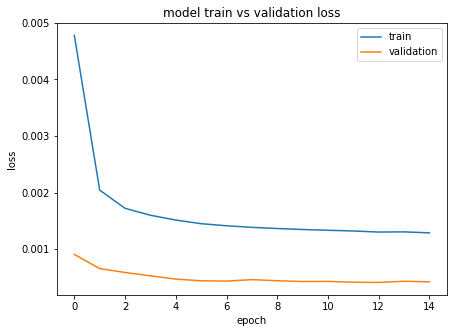

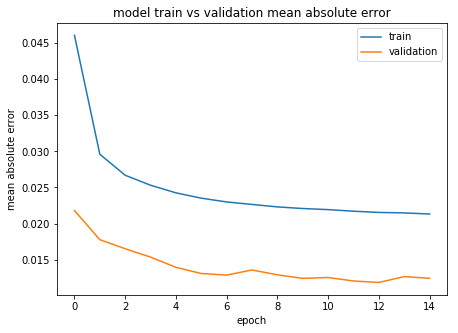

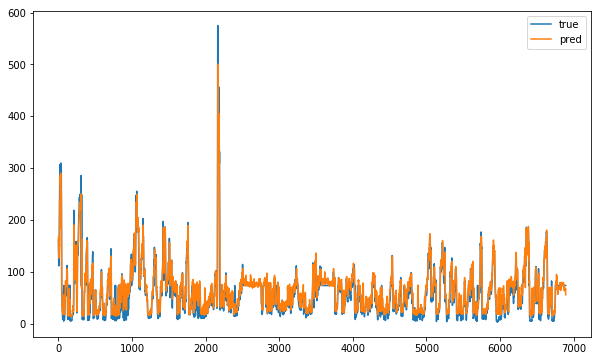

loss(test-set): 18.35514481191116

CNN_Filters:  15 LSTM_layer1:  76 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_3 (TimeDist (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 15)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 76)          27968     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 76)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 481)         1073592   
_______________________________________________________

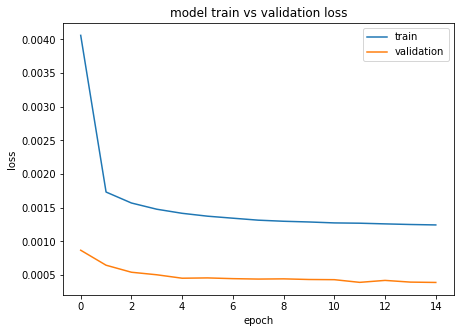

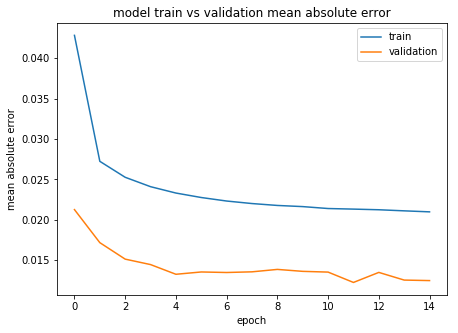

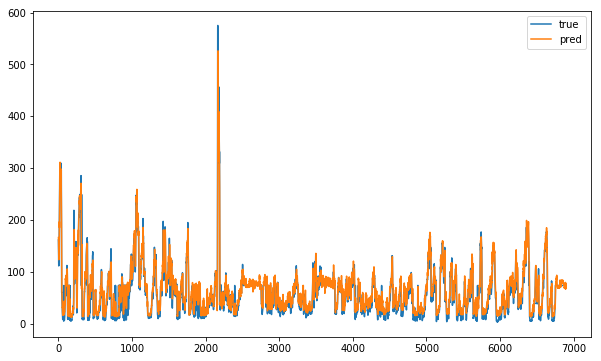

loss(test-set): 18.197775788966833

CNN_Filters:  17 LSTM_layer1:  849 LSTM_layer2:  91
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_6 (TimeDist (None, None, 2, 17)       153       
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 1, 17)       0         
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 17)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 849)         2944332   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 849)         0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 91)          342524    
______________________________________________________

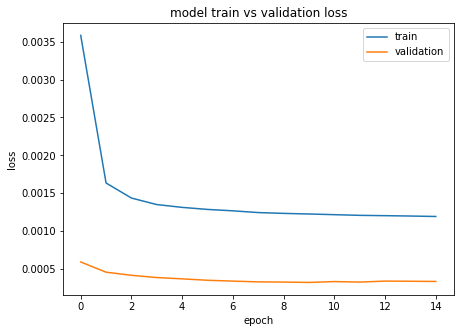

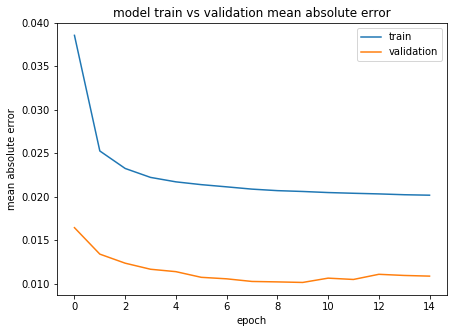

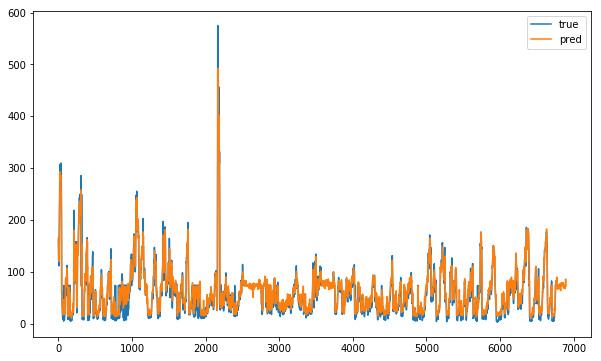

loss(test-set): 16.40684390858635

CNN_Filters:  5 LSTM_layer1:  414 LSTM_layer2:  120
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_9 (TimeDist (None, None, 2, 5)        45        
_________________________________________________________________
time_distributed_10 (TimeDis (None, None, 1, 5)        0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, None, 5)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, None, 414)         695520    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 414)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 120)         256800    
_______________________________________________________

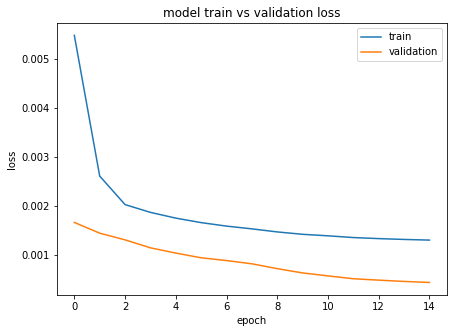

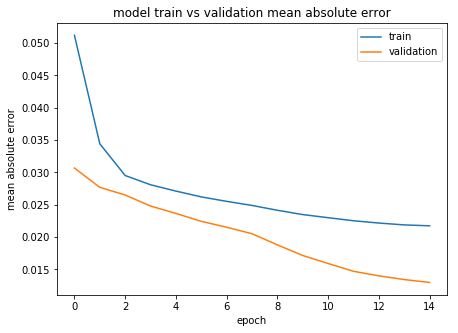

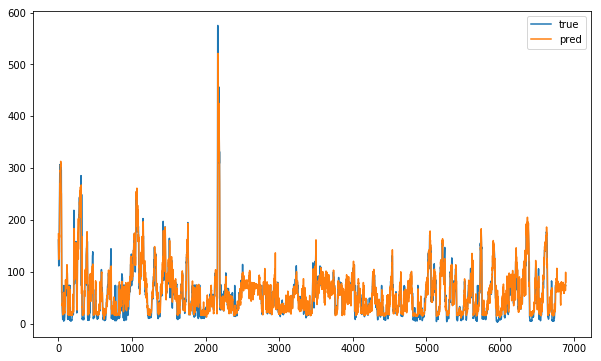

loss(test-set): 18.97483000485309

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  564
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_12 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_13 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_14 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 240)         244800    
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 240)         0         
_________________________________________________________________
lstm_9 (LSTM)                (None, None, 564)         1816080   
______________________________________________________

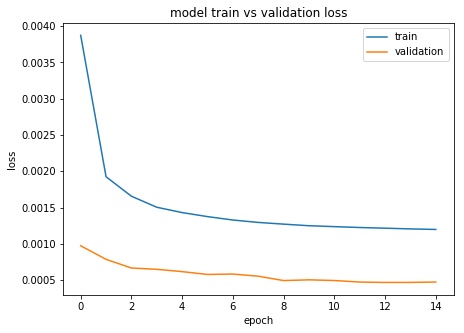

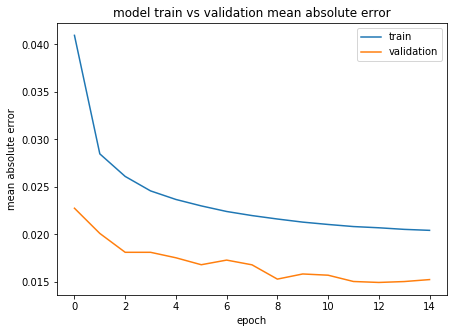

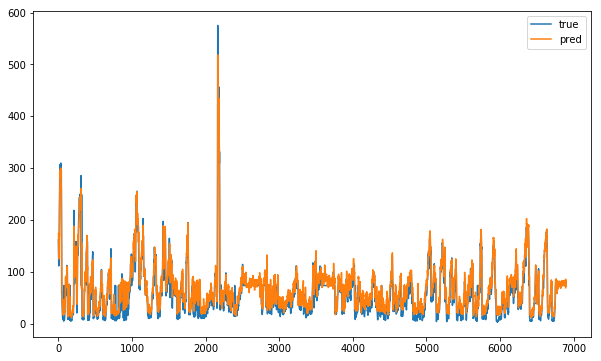

loss(test-set): 19.85890296614766

CNN_Filters:  10 LSTM_layer1:  487 LSTM_layer2:  952
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_15 (TimeDis (None, None, 2, 10)       90        
_________________________________________________________________
time_distributed_16 (TimeDis (None, None, 1, 10)       0         
_________________________________________________________________
time_distributed_17 (TimeDis (None, None, 10)          0         
_________________________________________________________________
lstm_10 (LSTM)               (None, None, 487)         970104    
_________________________________________________________________
dropout_10 (Dropout)         (None, None, 487)         0         
_________________________________________________________________
lstm_11 (LSTM)               (None, None, 952)         5483520   
______________________________________________________

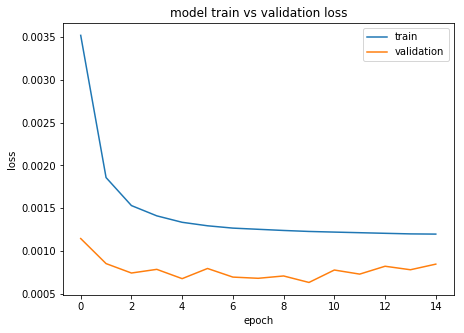

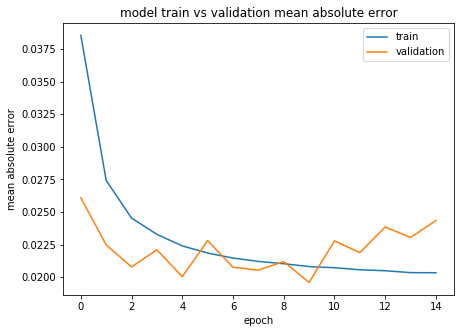

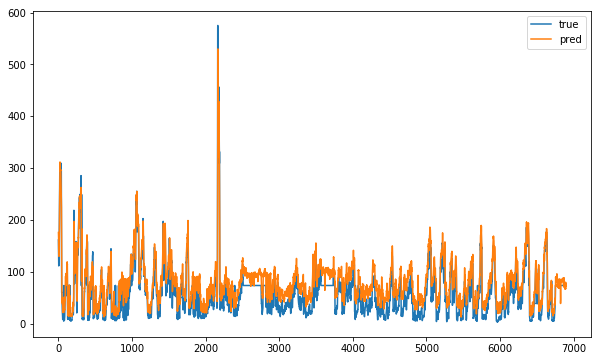

loss(test-set): 27.747115102105123

CNN_Filters:  21 LSTM_layer1:  88 LSTM_layer2:  372
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_18 (TimeDis (None, None, 2, 21)       189       
_________________________________________________________________
time_distributed_19 (TimeDis (None, None, 1, 21)       0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, None, 21)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, None, 88)          38720     
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 88)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, None, 372)         685968    
______________________________________________________

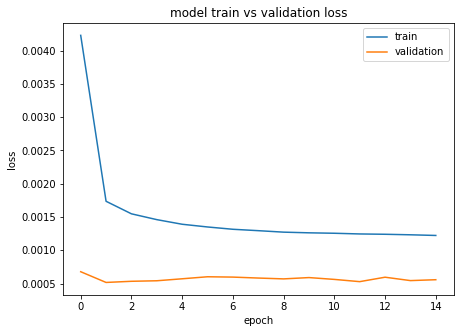

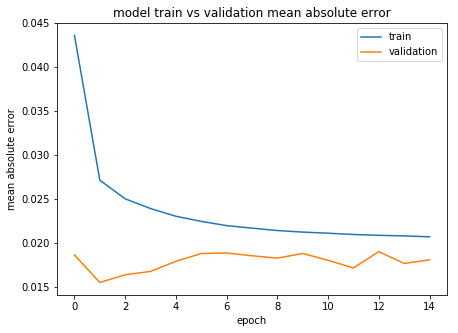

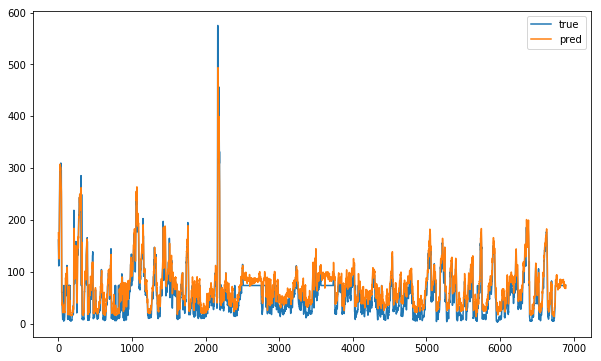

loss(test-set): 22.32916300502371

CNN_Filters:  13 LSTM_layer1:  457 LSTM_layer2:  213
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_21 (TimeDis (None, None, 2, 13)       117       
_________________________________________________________________
time_distributed_22 (TimeDis (None, None, 1, 13)       0         
_________________________________________________________________
time_distributed_23 (TimeDis (None, None, 13)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, None, 457)         860988    
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 457)         0         
_________________________________________________________________
lstm_15 (LSTM)               (None, None, 213)         571692    
______________________________________________________

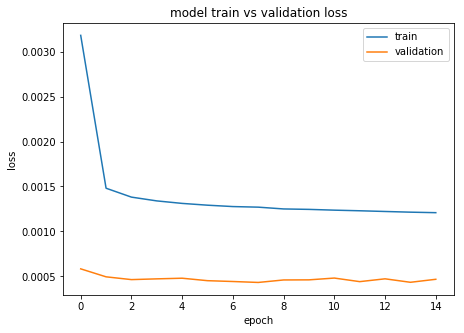

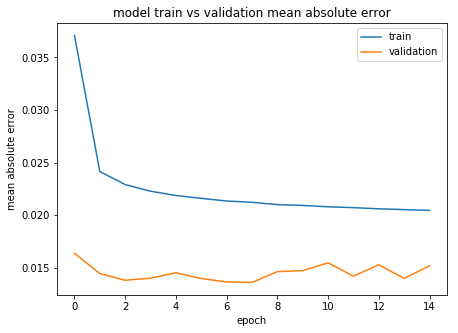

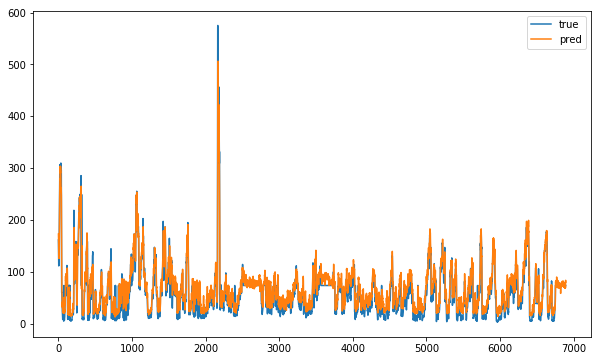

loss(test-set): 20.016494140329804

CNN_Filters:  8 LSTM_layer1:  473 LSTM_layer2:  811
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_24 (TimeDis (None, None, 2, 8)        72        
_________________________________________________________________
time_distributed_25 (TimeDis (None, None, 1, 8)        0         
_________________________________________________________________
time_distributed_26 (TimeDis (None, None, 8)           0         
_________________________________________________________________
lstm_16 (LSTM)               (None, None, 473)         911944    
_________________________________________________________________
dropout_16 (Dropout)         (None, None, 473)         0         
_________________________________________________________________
lstm_17 (LSTM)               (None, None, 811)         4168540   
______________________________________________________

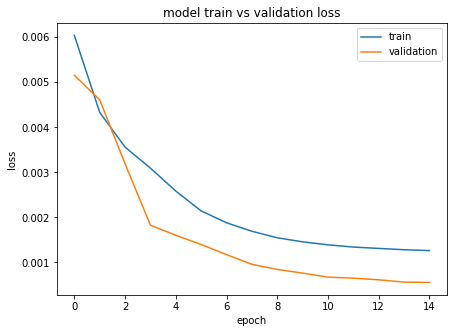

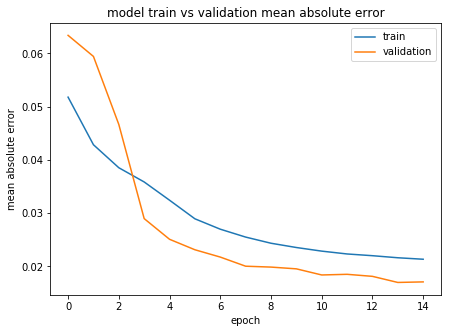

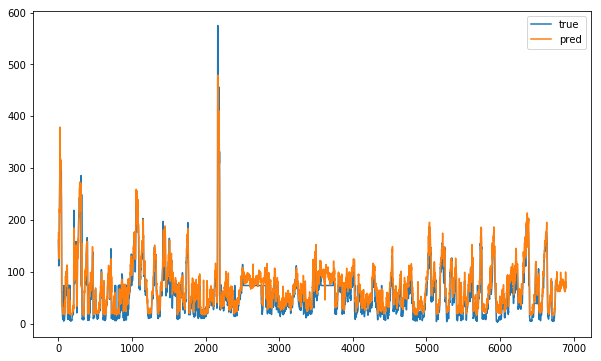

loss(test-set): 22.228829818491107

CNN_Filters:  1 LSTM_layer1:  100 LSTM_layer2:  580
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_27 (TimeDis (None, None, 2, 1)        9         
_________________________________________________________________
time_distributed_28 (TimeDis (None, None, 1, 1)        0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, None, 1)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, None, 100)         40800     
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 100)         0         
_________________________________________________________________
lstm_19 (LSTM)               (None, None, 580)         1579920   
______________________________________________________

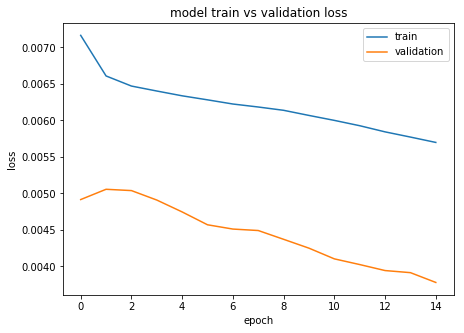

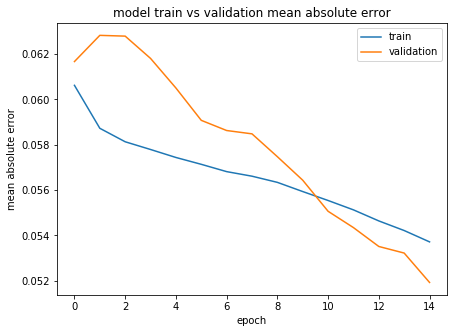

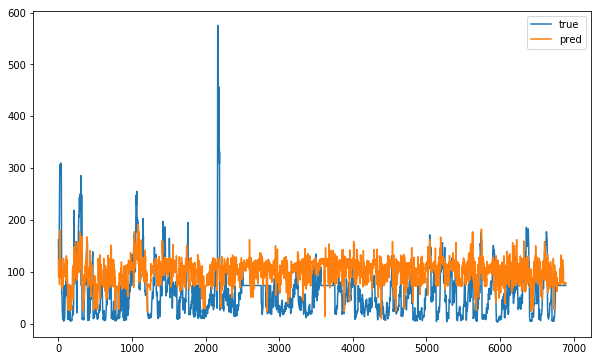

loss(test-set): 60.714098221703196
gen	nevals	avg    	std    	min    	max    
0  	10    	24.4829	12.4379	16.4068	60.7141

CNN_Filters:  15 LSTM_layer1:  76 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_30 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_31 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, None, 76)          27968     
_________________________________________________________________
dropout_20 (Dropout)         (None, None, 76)          0         
_________________________________________________________________
lstm_21 (LSTM)               (None

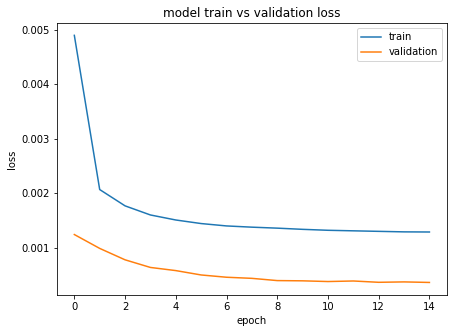

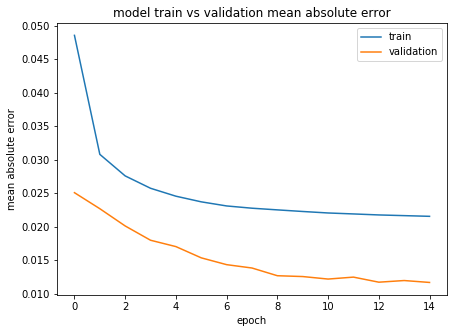

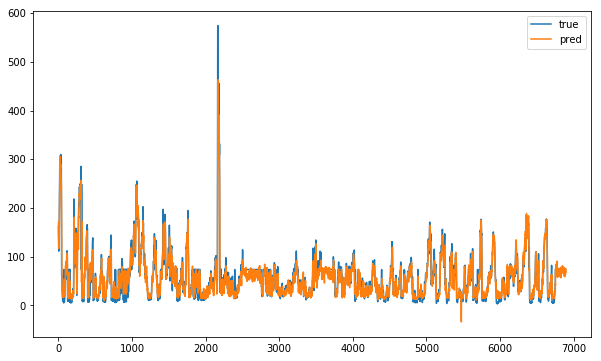

loss(test-set): 17.768099867693234

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  539
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_33 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_34 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_22 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_22 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_23 (LSTM)               (None, None, 539)         1681680   
_____________________________________________________

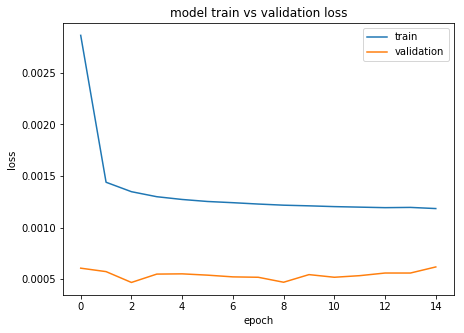

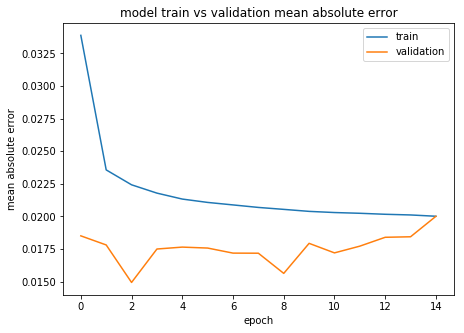

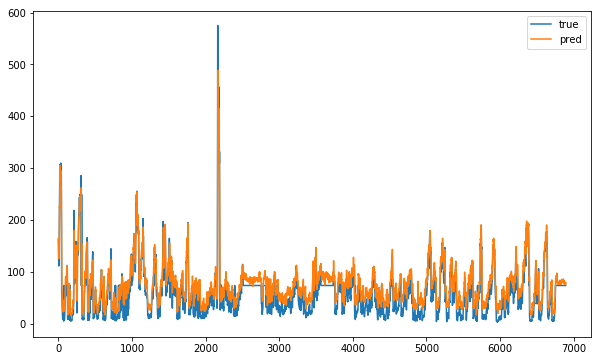

loss(test-set): 23.559465862519072

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_36 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_37 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_24 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_25 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

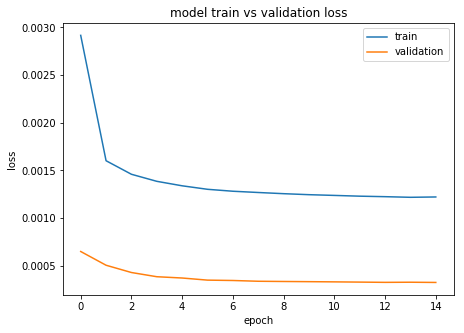

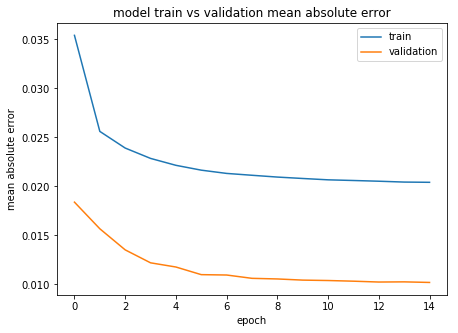

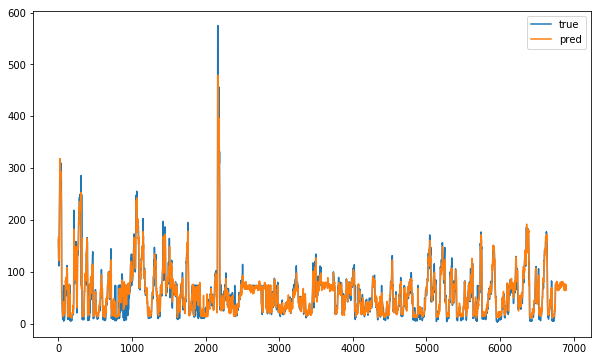

loss(test-set): 16.17086887986832

CNN_Filters:  21 LSTM_layer1:  88 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, None, 2, 21)       189       
_________________________________________________________________
time_distributed_40 (TimeDis (None, None, 1, 21)       0         
_________________________________________________________________
time_distributed_41 (TimeDis (None, None, 21)          0         
_________________________________________________________________
lstm_26 (LSTM)               (None, None, 88)          38720     
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 88)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, None, 481)         1096680   
_______________________________________________________

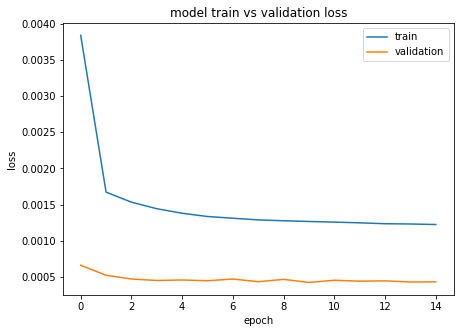

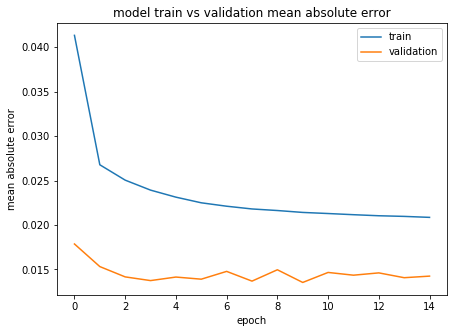

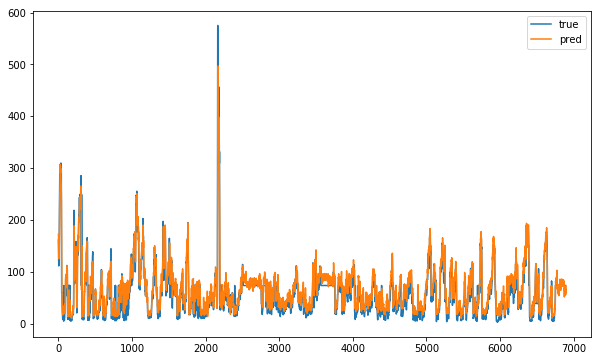

loss(test-set): 19.44038273239838

CNN_Filters:  21 LSTM_layer1:  88 LSTM_layer2:  564
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_42 (TimeDis (None, None, 2, 21)       189       
_________________________________________________________________
time_distributed_43 (TimeDis (None, None, 1, 21)       0         
_________________________________________________________________
time_distributed_44 (TimeDis (None, None, 21)          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, None, 88)          38720     
_________________________________________________________________
dropout_28 (Dropout)         (None, None, 88)          0         
_________________________________________________________________
lstm_29 (LSTM)               (None, None, 564)         1473168   
_______________________________________________________

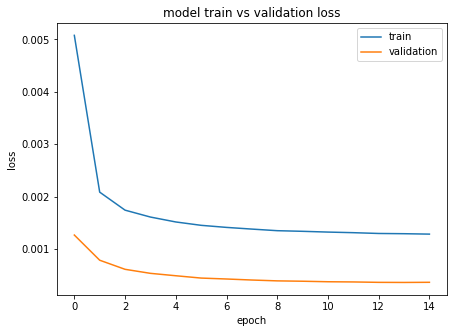

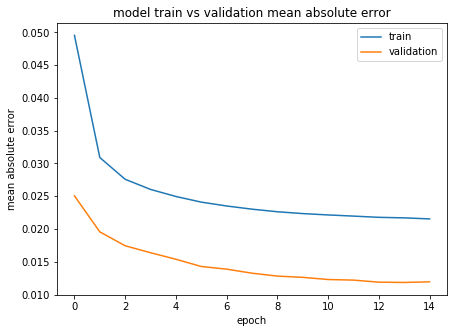

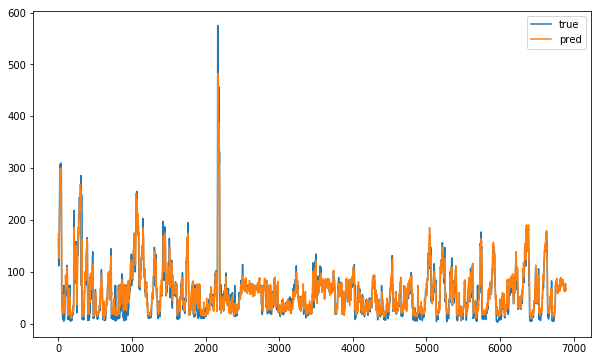

loss(test-set): 17.80538951237553

CNN_Filters:  27 LSTM_layer1:  331 LSTM_layer2:  400
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_45 (TimeDis (None, None, 2, 27)       243       
_________________________________________________________________
time_distributed_46 (TimeDis (None, None, 1, 27)       0         
_________________________________________________________________
time_distributed_47 (TimeDis (None, None, 27)          0         
_________________________________________________________________
lstm_30 (LSTM)               (None, None, 331)         475316    
_________________________________________________________________
dropout_30 (Dropout)         (None, None, 331)         0         
_________________________________________________________________
lstm_31 (LSTM)               (None, None, 400)         1171200   
______________________________________________________

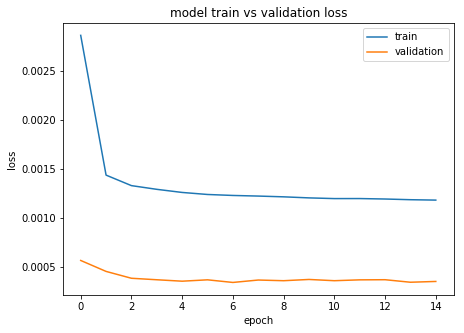

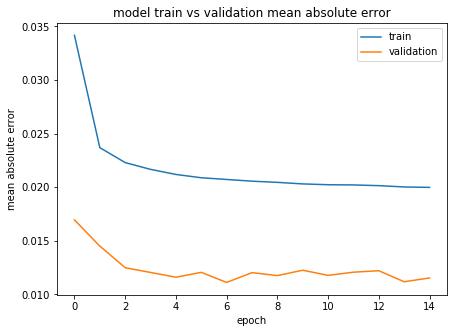

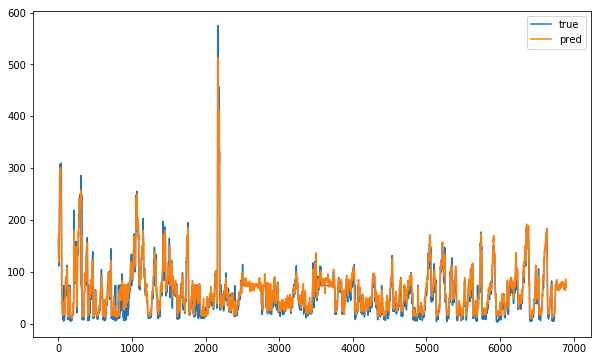

loss(test-set): 16.846595013578234

CNN_Filters:  21 LSTM_layer1:  89 LSTM_layer2:  811
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_48 (TimeDis (None, None, 2, 21)       189       
_________________________________________________________________
time_distributed_49 (TimeDis (None, None, 1, 21)       0         
_________________________________________________________________
time_distributed_50 (TimeDis (None, None, 21)          0         
_________________________________________________________________
lstm_32 (LSTM)               (None, None, 89)          39516     
_________________________________________________________________
dropout_32 (Dropout)         (None, None, 89)          0         
_________________________________________________________________
lstm_33 (LSTM)               (None, None, 811)         2922844   
______________________________________________________

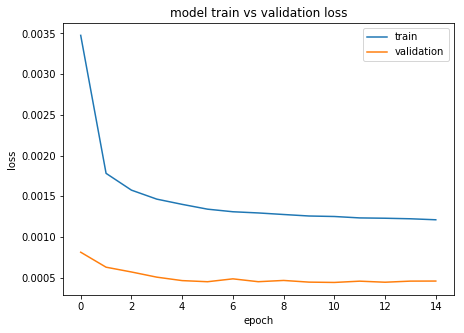

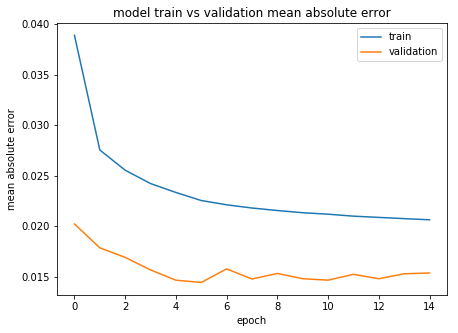

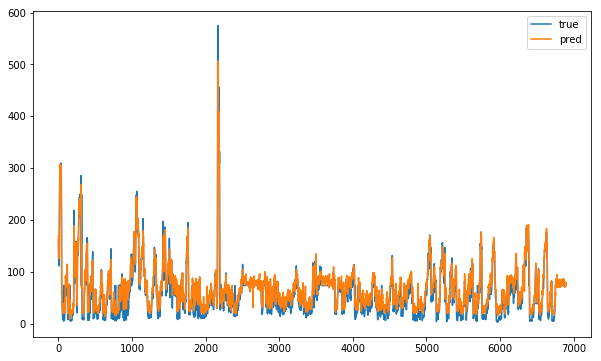

loss(test-set): 20.164547731096672
1  	7     	17.8129	1.17192	16.1709	20.1645

CNN_Filters:  15 LSTM_layer1:  76 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_51 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_52 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_53 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_34 (LSTM)               (None, None, 76)          27968     
_________________________________________________________________
dropout_34 (Dropout)         (None, None, 76)          0         
_________________________________________________________________
lstm_35 (LSTM)               (None, None, 993)         4250040   
___________

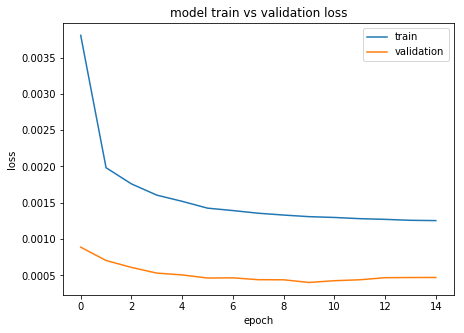

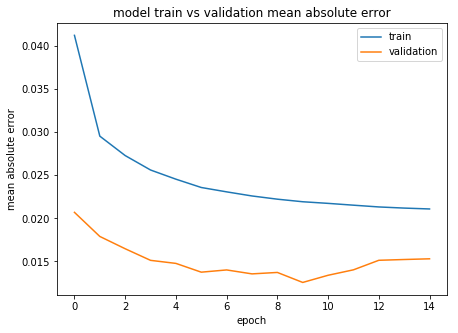

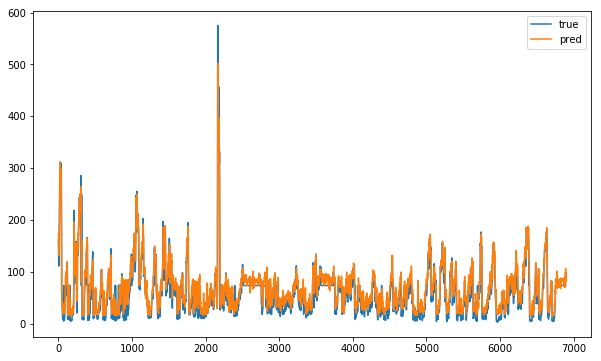

loss(test-set): 20.267818207357887

CNN_Filters:  29 LSTM_layer1:  840 LSTM_layer2:  910
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_54 (TimeDis (None, None, 2, 29)       261       
_________________________________________________________________
time_distributed_55 (TimeDis (None, None, 1, 29)       0         
_________________________________________________________________
time_distributed_56 (TimeDis (None, None, 29)          0         
_________________________________________________________________
lstm_36 (LSTM)               (None, None, 840)         2923200   
_________________________________________________________________
dropout_36 (Dropout)         (None, None, 840)         0         
_________________________________________________________________
lstm_37 (LSTM)               (None, None, 910)         6373640   
_____________________________________________________

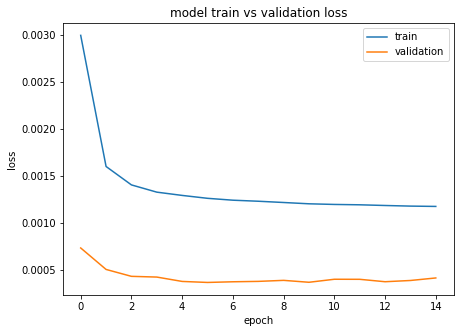

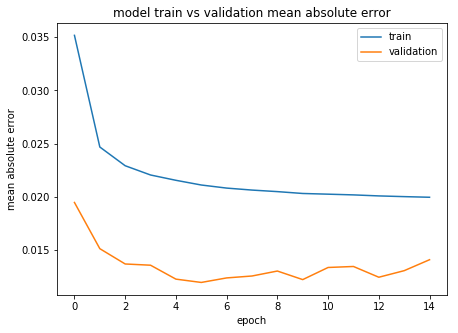

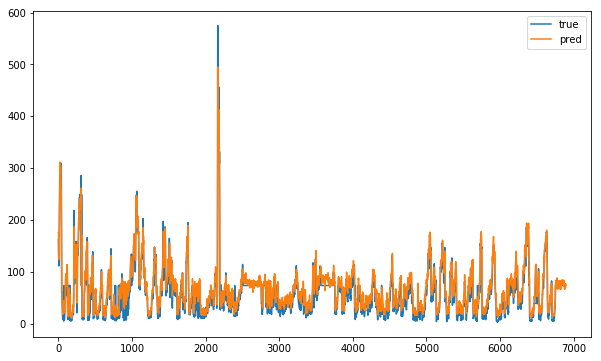

loss(test-set): 18.593979523847278

CNN_Filters:  15 LSTM_layer1:  76 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_57 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_58 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_59 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, None, 76)          27968     
_________________________________________________________________
dropout_38 (Dropout)         (None, None, 76)          0         
_________________________________________________________________
lstm_39 (LSTM)               (None, None, 481)         1073592   
______________________________________________________

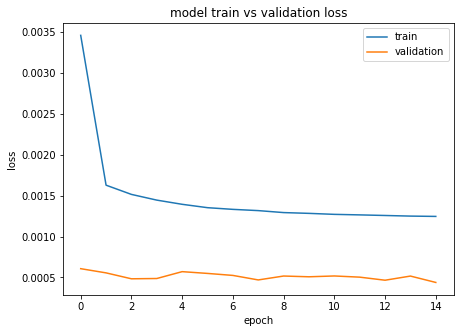

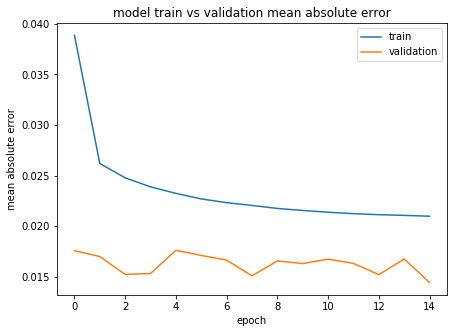

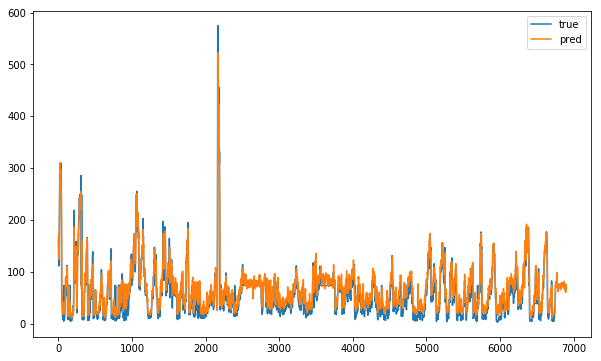

loss(test-set): 19.541484008563383

CNN_Filters:  15 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_60 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_61 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_62 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, None, 240)         245760    
_________________________________________________________________
dropout_40 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_41 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

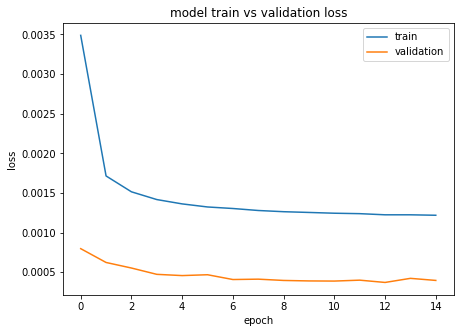

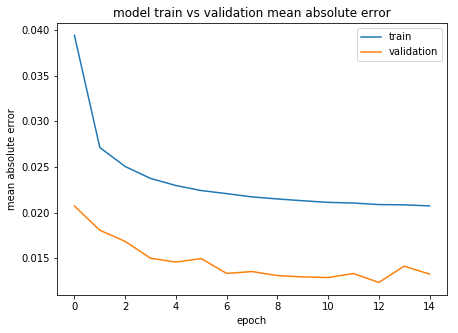

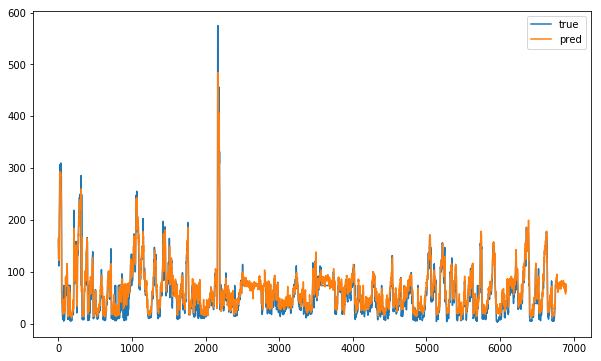

loss(test-set): 18.534112065151866

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_63 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_64 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_65 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_42 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_42 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_43 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

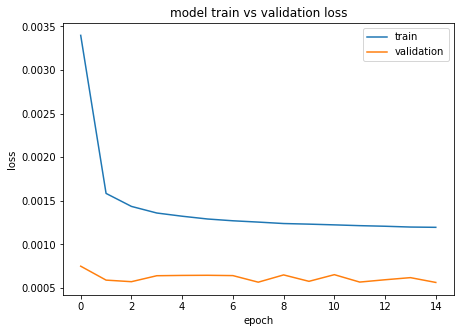

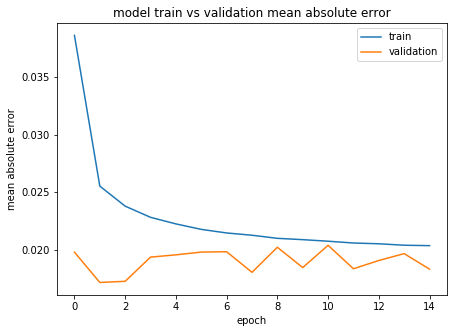

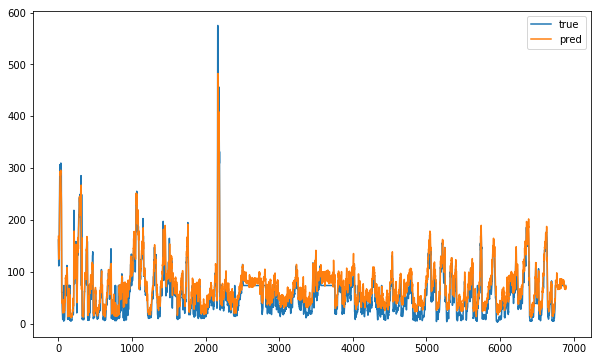

loss(test-set): 22.40138937961574

CNN_Filters:  8 LSTM_layer1:  370 LSTM_layer2:  991
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_66 (TimeDis (None, None, 2, 8)        72        
_________________________________________________________________
time_distributed_67 (TimeDis (None, None, 1, 8)        0         
_________________________________________________________________
time_distributed_68 (TimeDis (None, None, 8)           0         
_________________________________________________________________
lstm_44 (LSTM)               (None, None, 370)         560920    
_________________________________________________________________
dropout_44 (Dropout)         (None, None, 370)         0         
_________________________________________________________________
lstm_45 (LSTM)               (None, None, 991)         5398968   
_______________________________________________________

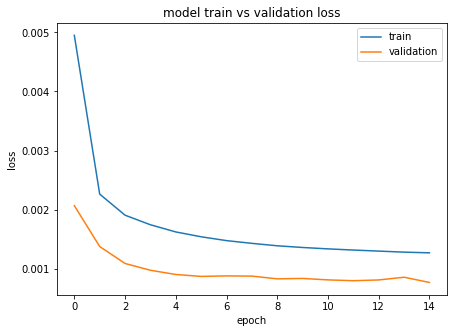

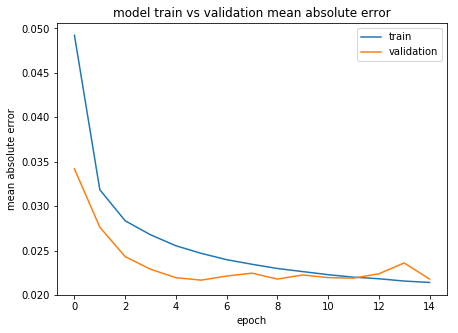

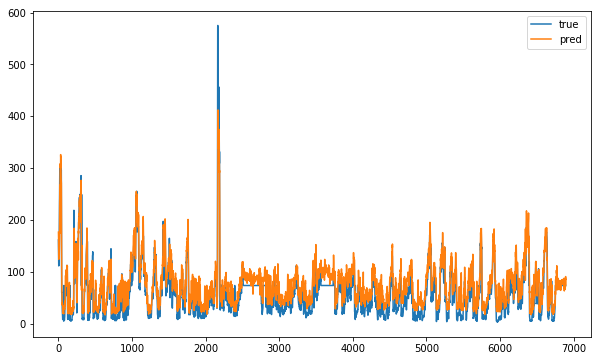

loss(test-set): 26.23509229767218

CNN_Filters:  15 LSTM_layer1:  76 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_69 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_70 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_46 (LSTM)               (None, None, 76)          27968     
_________________________________________________________________
dropout_46 (Dropout)         (None, None, 76)          0         
_________________________________________________________________
lstm_47 (LSTM)               (None, None, 481)         1073592   
_______________________________________________________

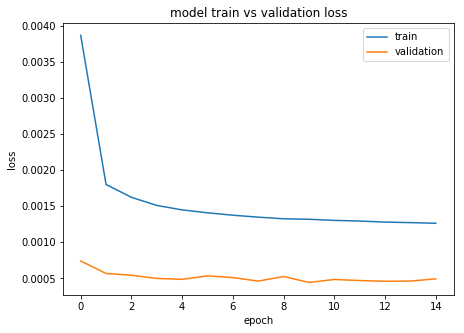

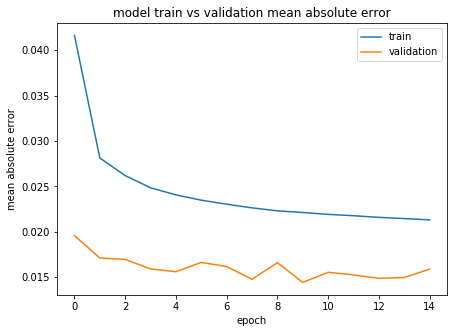

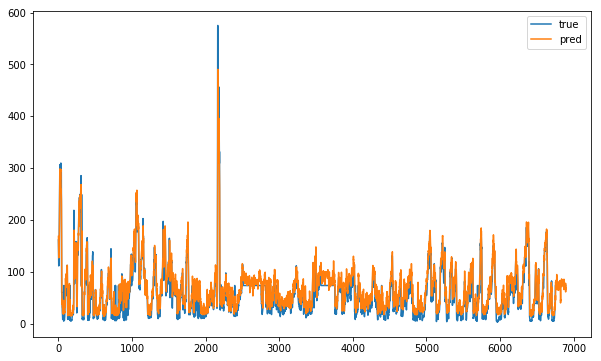

loss(test-set): 20.799196962323563

CNN_Filters:  27 LSTM_layer1:  331 LSTM_layer2:  481
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_72 (TimeDis (None, None, 2, 27)       243       
_________________________________________________________________
time_distributed_73 (TimeDis (None, None, 1, 27)       0         
_________________________________________________________________
time_distributed_74 (TimeDis (None, None, 27)          0         
_________________________________________________________________
lstm_48 (LSTM)               (None, None, 331)         475316    
_________________________________________________________________
dropout_48 (Dropout)         (None, None, 331)         0         
_________________________________________________________________
lstm_49 (LSTM)               (None, None, 481)         1564212   
_____________________________________________________

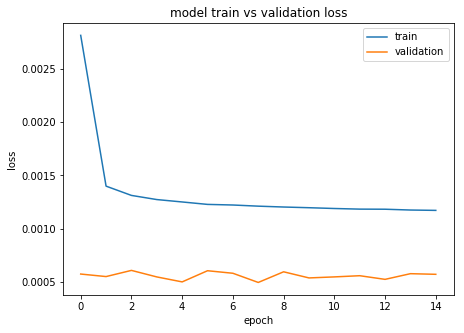

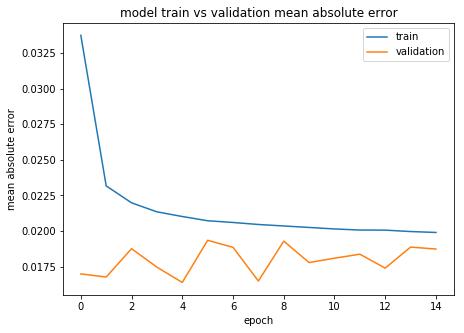

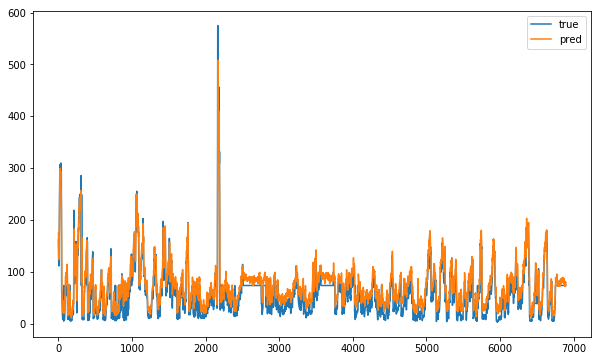

loss(test-set): 22.39316817213053
2  	8     	16.9806	1.26391	16.1709	19.5415

CNN_Filters:  15 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_75 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_76 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_77 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_50 (LSTM)               (None, None, 240)         245760    
_________________________________________________________________
dropout_50 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_51 (LSTM)               (None, None, 993)         4901448   
___________

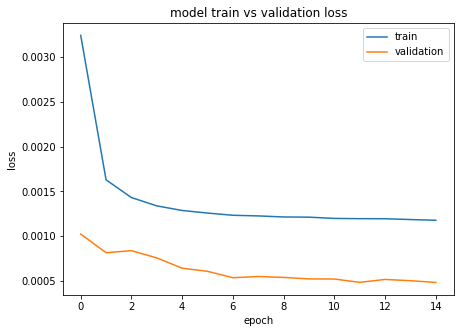

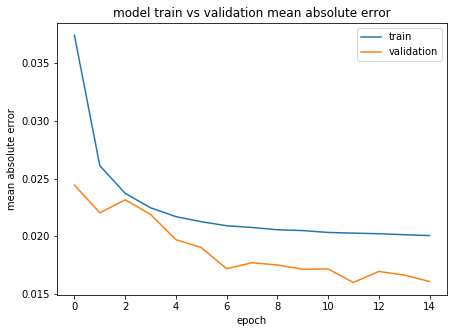

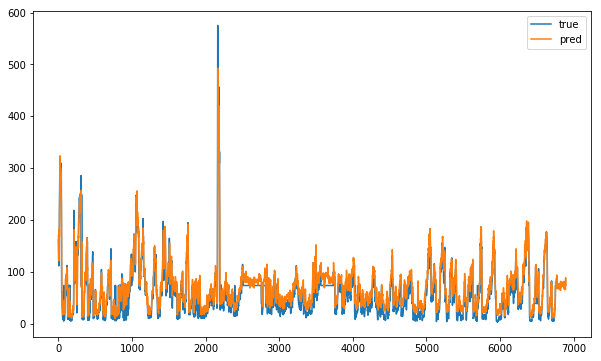

loss(test-set): 20.48868192965146

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_78 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_79 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_80 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_52 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_52 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_53 (LSTM)               (None, None, 993)         4901448   
______________________________________________________

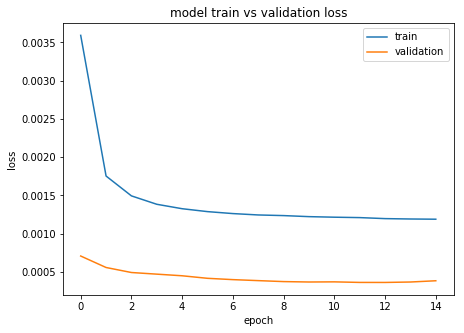

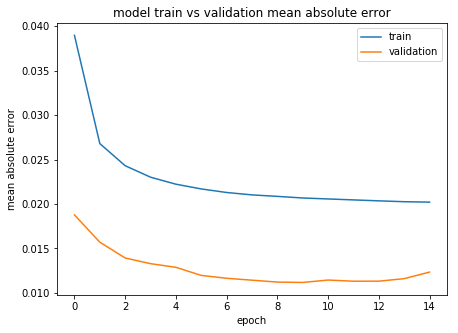

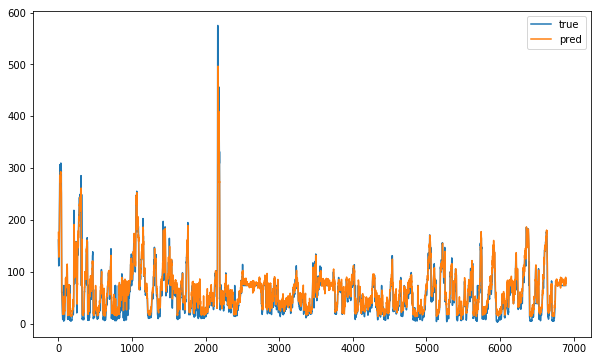

loss(test-set): 17.91033257885641

CNN_Filters:  15 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_81 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_82 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_83 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_54 (LSTM)               (None, None, 240)         245760    
_________________________________________________________________
dropout_54 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_55 (LSTM)               (None, None, 993)         4901448   
______________________________________________________

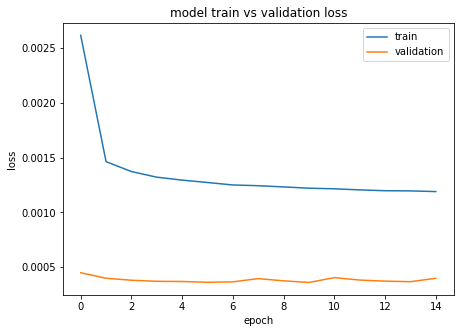

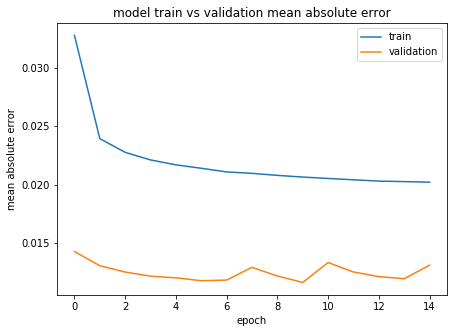

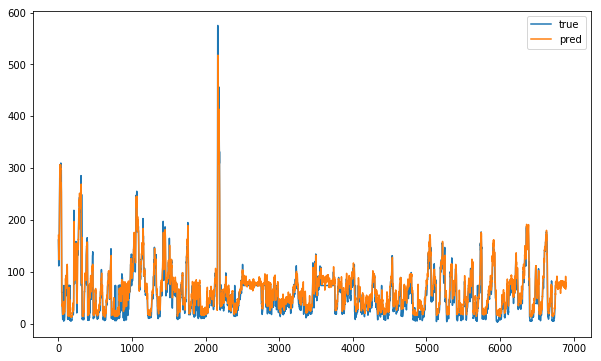

loss(test-set): 18.327492906852047

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_84 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_85 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_86 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_56 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_56 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_57 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

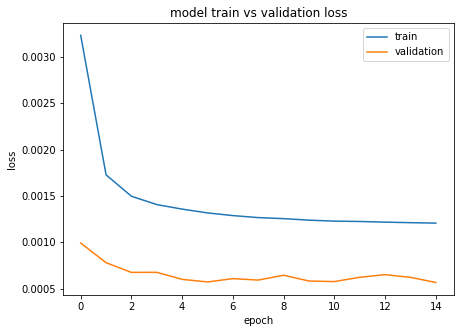

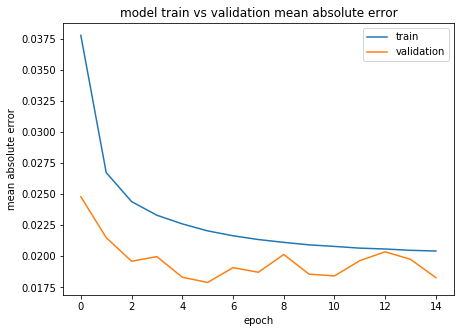

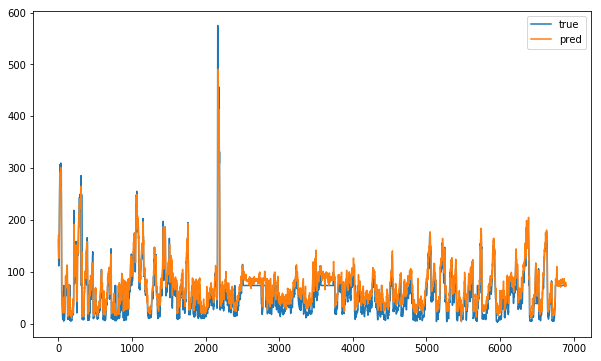

loss(test-set): 22.340295255163156

CNN_Filters:  15 LSTM_layer1:  112 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_87 (TimeDis (None, None, 2, 15)       135       
_________________________________________________________________
time_distributed_88 (TimeDis (None, None, 1, 15)       0         
_________________________________________________________________
time_distributed_89 (TimeDis (None, None, 15)          0         
_________________________________________________________________
lstm_58 (LSTM)               (None, None, 112)         57344     
_________________________________________________________________
dropout_58 (Dropout)         (None, None, 112)         0         
_________________________________________________________________
lstm_59 (LSTM)               (None, None, 993)         4393032   
_____________________________________________________

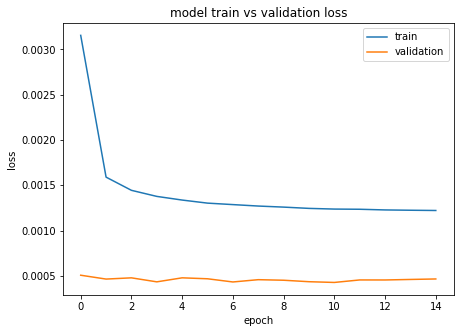

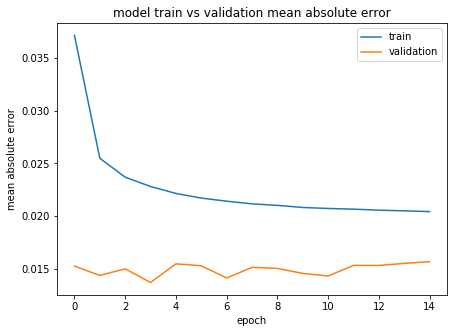

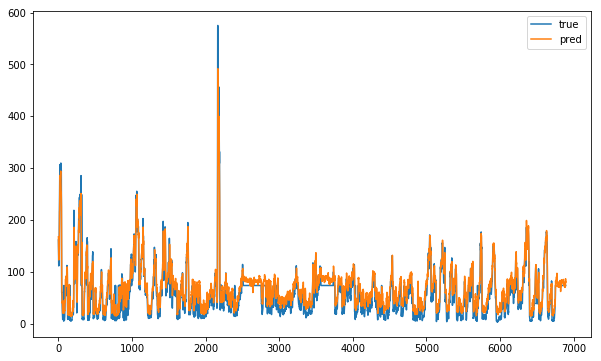

loss(test-set): 20.14198308020997

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_90 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_91 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_92 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_60 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_60 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_61 (LSTM)               (None, None, 993)         4901448   
______________________________________________________

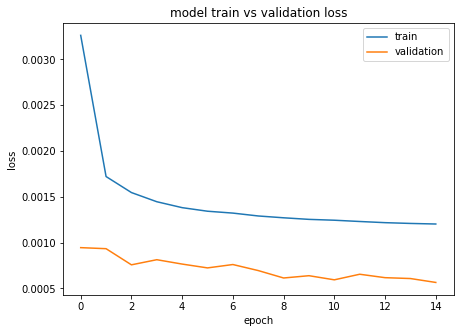

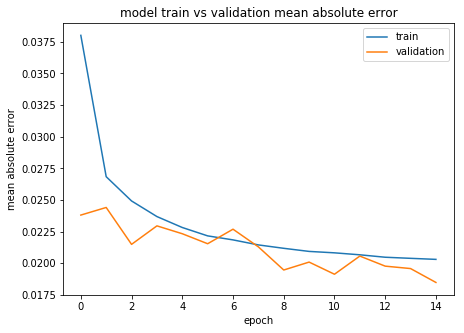

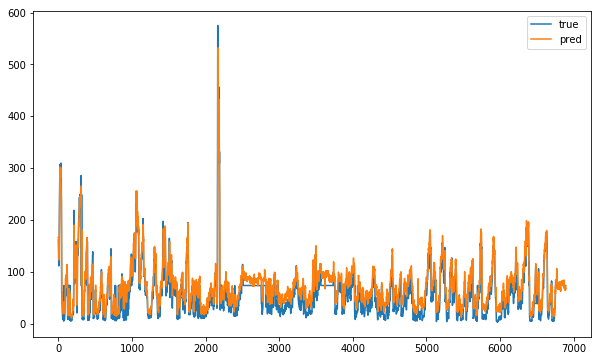

loss(test-set): 22.348033341310284
3  	6     	18.0814	1.72364	16.1709	22.3403

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_93 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_94 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_95 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_62 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_62 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_63 (LSTM)               (None, None, 993)         4901448   
__________

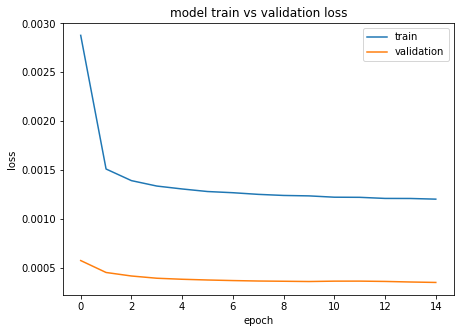

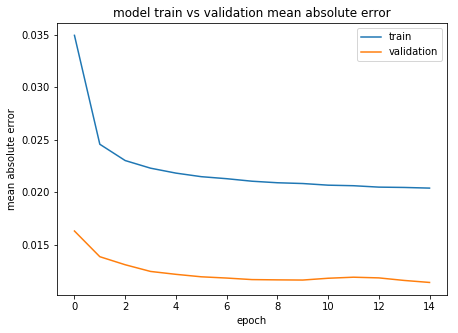

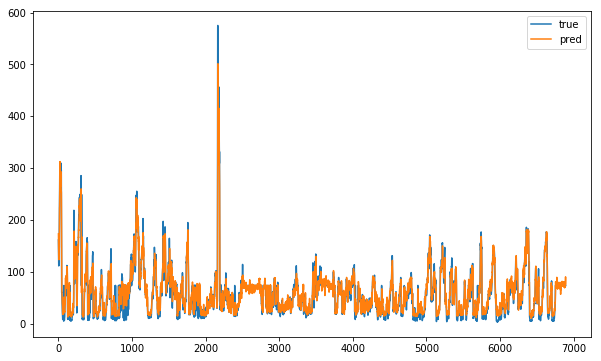

loss(test-set): 17.035341726162727

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_96 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_97 (TimeDis (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_98 (TimeDis (None, None, 14)          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_64 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_65 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

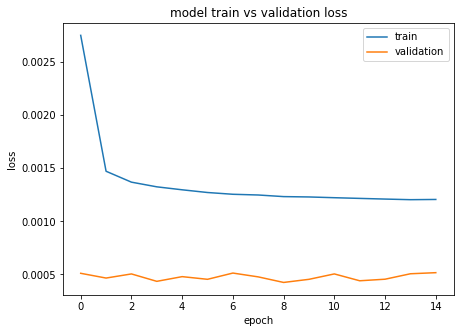

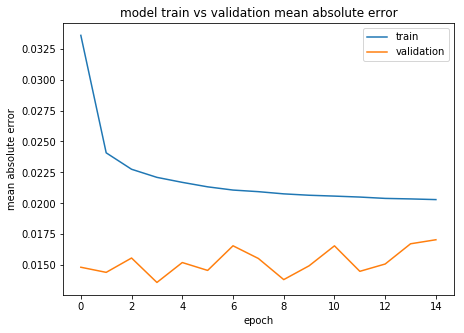

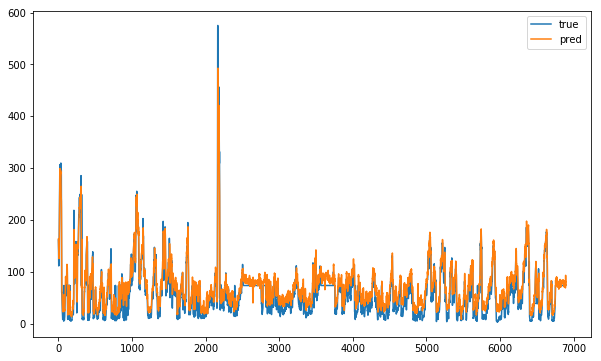

loss(test-set): 21.427646608615913

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_99 (TimeDis (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_100 (TimeDi (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_101 (TimeDi (None, None, 14)          0         
_________________________________________________________________
lstm_66 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_66 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_67 (LSTM)               (None, None, 993)         4901448   
_____________________________________________________

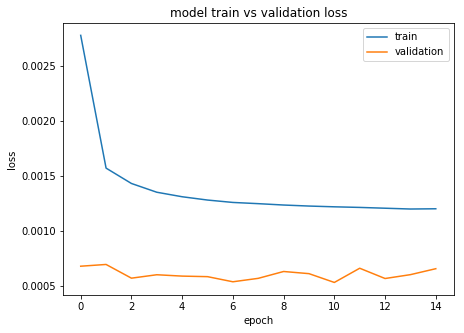

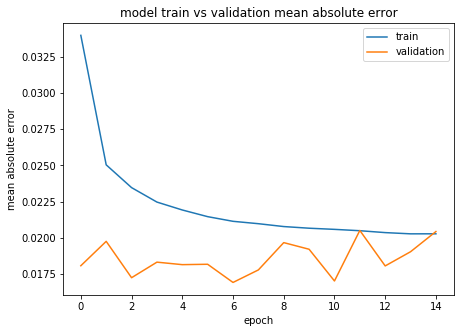

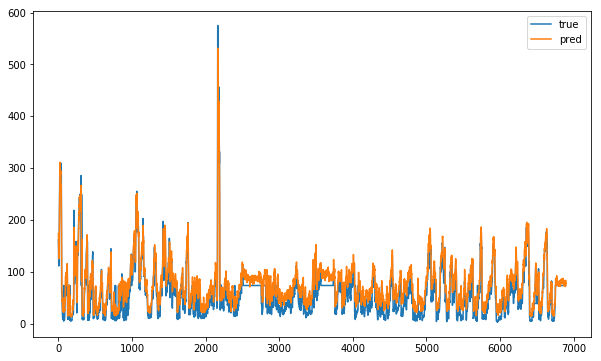

loss(test-set): 24.16202573170374

CNN_Filters:  28 LSTM_layer1:  915 LSTM_layer2:  359
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_102 (TimeDi (None, None, 2, 28)       252       
_________________________________________________________________
time_distributed_103 (TimeDi (None, None, 1, 28)       0         
_________________________________________________________________
time_distributed_104 (TimeDi (None, None, 28)          0         
_________________________________________________________________
lstm_68 (LSTM)               (None, None, 915)         3455040   
_________________________________________________________________
dropout_68 (Dropout)         (None, None, 915)         0         
_________________________________________________________________
lstm_69 (LSTM)               (None, None, 359)         1830900   
______________________________________________________

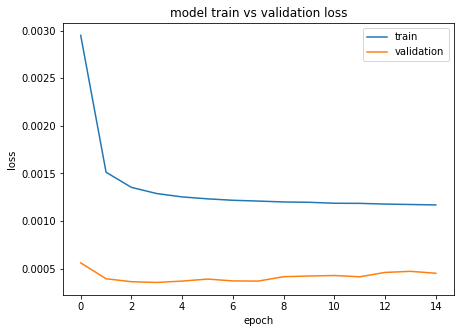

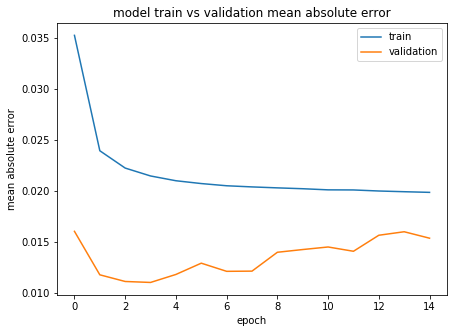

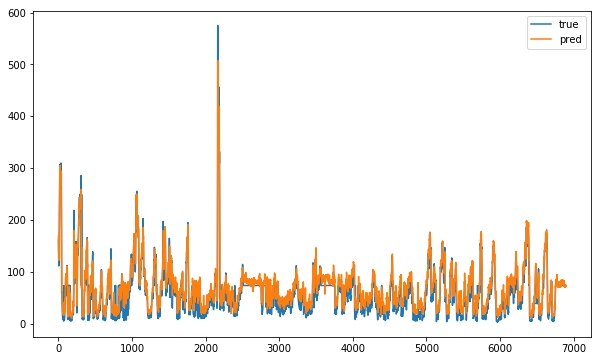

loss(test-set): 19.427373258924046

CNN_Filters:  24 LSTM_layer1:  284 LSTM_layer2:  846
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_105 (TimeDi (None, None, 2, 24)       216       
_________________________________________________________________
time_distributed_106 (TimeDi (None, None, 1, 24)       0         
_________________________________________________________________
time_distributed_107 (TimeDi (None, None, 24)          0         
_________________________________________________________________
lstm_70 (LSTM)               (None, None, 284)         351024    
_________________________________________________________________
dropout_70 (Dropout)         (None, None, 284)         0         
_________________________________________________________________
lstm_71 (LSTM)               (None, None, 846)         3827304   
_____________________________________________________

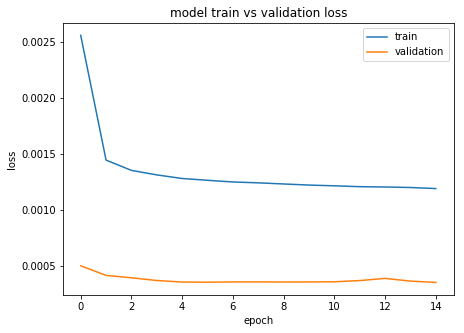

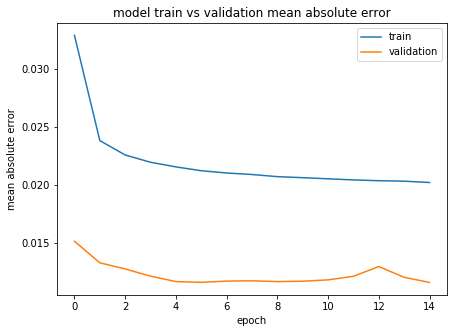

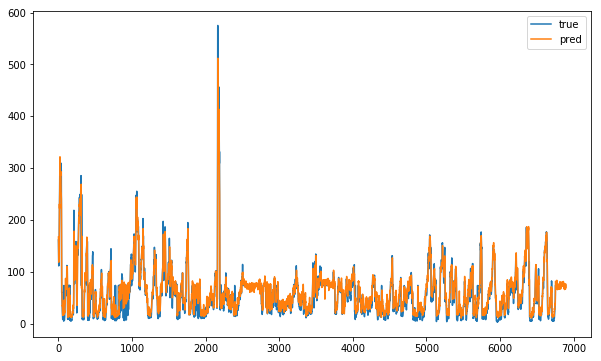

loss(test-set): 17.00286548780665

CNN_Filters:  17 LSTM_layer1:  730 LSTM_layer2:  583
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_108 (TimeDi (None, None, 2, 17)       153       
_________________________________________________________________
time_distributed_109 (TimeDi (None, None, 1, 17)       0         
_________________________________________________________________
time_distributed_110 (TimeDi (None, None, 17)          0         
_________________________________________________________________
lstm_72 (LSTM)               (None, None, 730)         2184160   
_________________________________________________________________
dropout_72 (Dropout)         (None, None, 730)         0         
_________________________________________________________________
lstm_73 (LSTM)               (None, None, 583)         3064248   
______________________________________________________

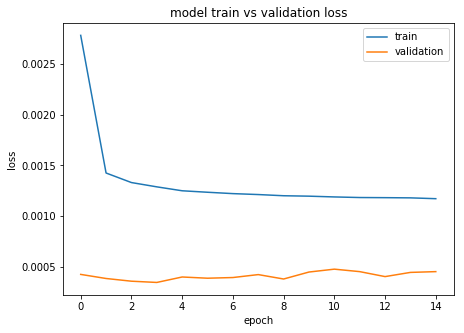

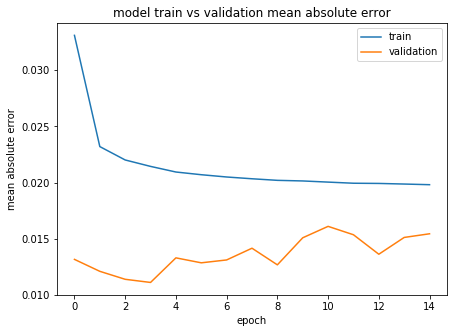

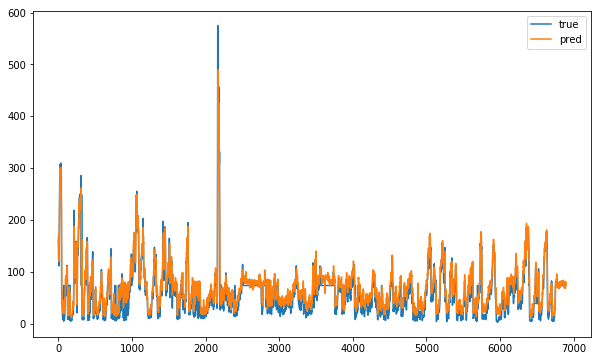

loss(test-set): 19.67069661665472
4  	6     	16.9029	1.1369 	16.1709	19.6707

CNN_Filters:  24 LSTM_layer1:  284 LSTM_layer2:  847
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_111 (TimeDi (None, None, 2, 24)       216       
_________________________________________________________________
time_distributed_112 (TimeDi (None, None, 1, 24)       0         
_________________________________________________________________
time_distributed_113 (TimeDi (None, None, 24)          0         
_________________________________________________________________
lstm_74 (LSTM)               (None, None, 284)         351024    
_________________________________________________________________
dropout_74 (Dropout)         (None, None, 284)         0         
_________________________________________________________________
lstm_75 (LSTM)               (None, None, 847)         3835216   
___________

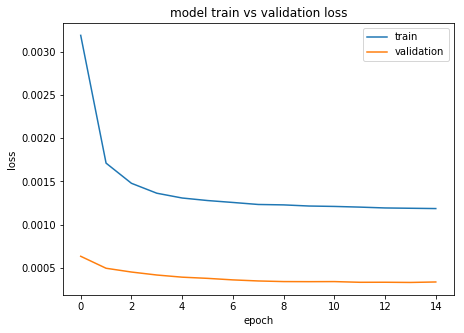

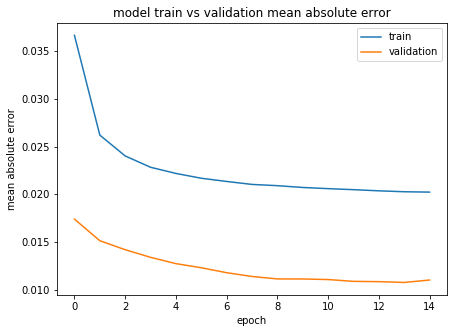

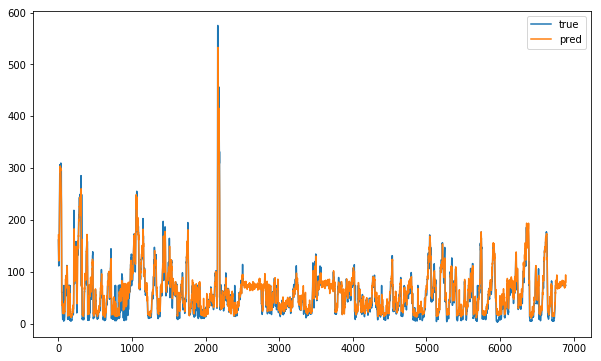

loss(test-set): 16.595782502843768

CNN_Filters:  17 LSTM_layer1:  752 LSTM_layer2:  993
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_114 (TimeDi (None, None, 2, 17)       153       
_________________________________________________________________
time_distributed_115 (TimeDi (None, None, 1, 17)       0         
_________________________________________________________________
time_distributed_116 (TimeDi (None, None, 17)          0         
_________________________________________________________________
lstm_76 (LSTM)               (None, None, 752)         2316160   
_________________________________________________________________
dropout_76 (Dropout)         (None, None, 752)         0         
_________________________________________________________________
lstm_77 (LSTM)               (None, None, 993)         6935112   
_____________________________________________________

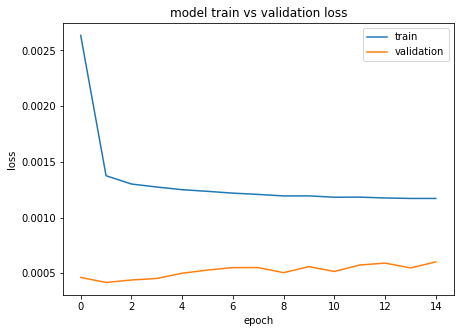

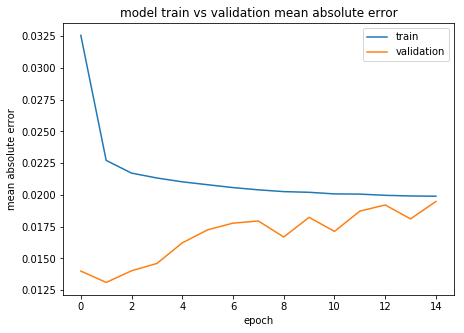

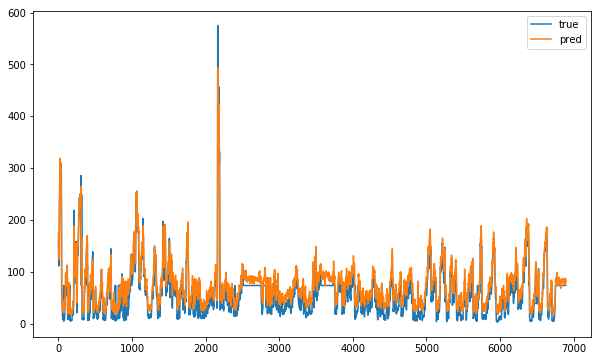

loss(test-set): 22.946053061452986

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  967
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_117 (TimeDi (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_118 (TimeDi (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_119 (TimeDi (None, None, 14)          0         
_________________________________________________________________
lstm_78 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_78 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_79 (LSTM)               (None, None, 967)         4672544   
_____________________________________________________

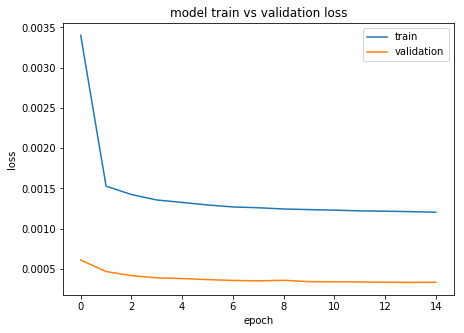

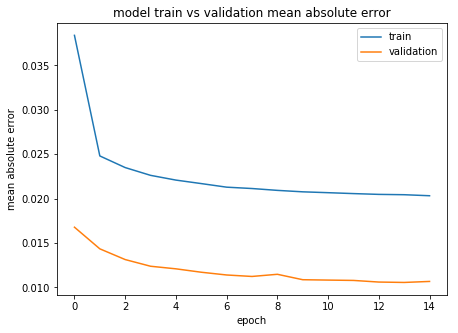

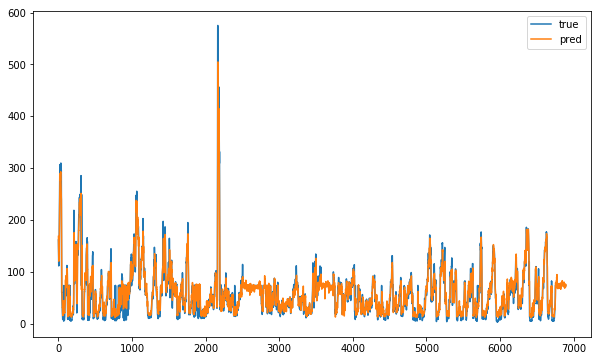

loss(test-set): 16.638229666574272

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  1006
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_120 (TimeDi (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_121 (TimeDi (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_122 (TimeDi (None, None, 14)          0         
_________________________________________________________________
lstm_80 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_80 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_81 (LSTM)               (None, None, 1006)        5017928   
____________________________________________________

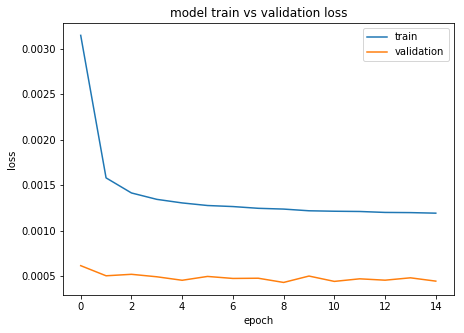

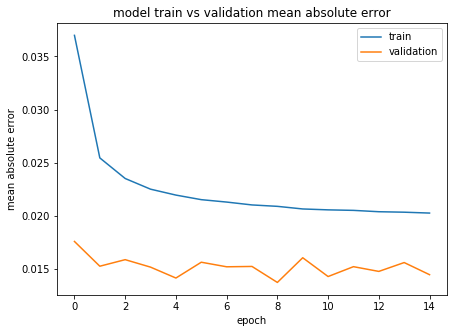

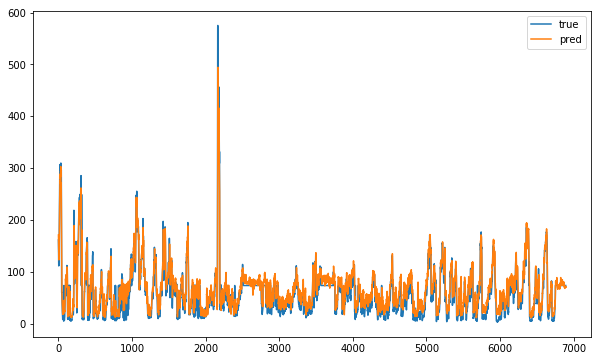

loss(test-set): 19.470146561912383

CNN_Filters:  24 LSTM_layer1:  284 LSTM_layer2:  865
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_123 (TimeDi (None, None, 2, 24)       216       
_________________________________________________________________
time_distributed_124 (TimeDi (None, None, 1, 24)       0         
_________________________________________________________________
time_distributed_125 (TimeDi (None, None, 24)          0         
_________________________________________________________________
lstm_82 (LSTM)               (None, None, 284)         351024    
_________________________________________________________________
dropout_82 (Dropout)         (None, None, 284)         0         
_________________________________________________________________
lstm_83 (LSTM)               (None, None, 865)         3979000   
_____________________________________________________

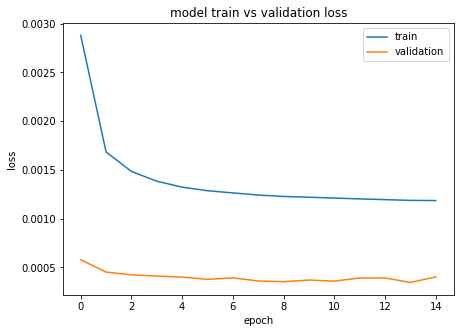

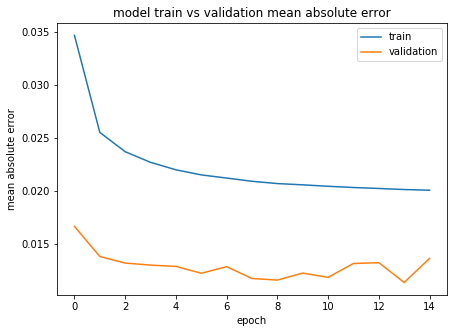

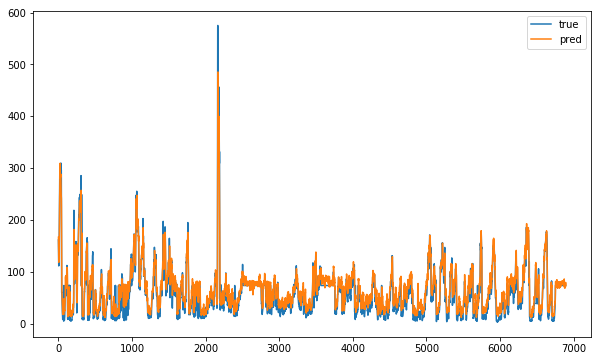

loss(test-set): 18.48956616439055

CNN_Filters:  14 LSTM_layer1:  240 LSTM_layer2:  992
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_126 (TimeDi (None, None, 2, 14)       126       
_________________________________________________________________
time_distributed_127 (TimeDi (None, None, 1, 14)       0         
_________________________________________________________________
time_distributed_128 (TimeDi (None, None, 14)          0         
_________________________________________________________________
lstm_84 (LSTM)               (None, None, 240)         244800    
_________________________________________________________________
dropout_84 (Dropout)         (None, None, 240)         0         
_________________________________________________________________
lstm_85 (LSTM)               (None, None, 992)         4892544   
______________________________________________________

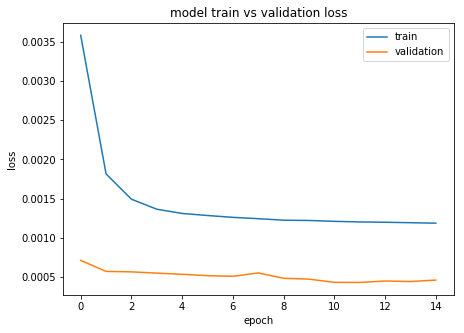

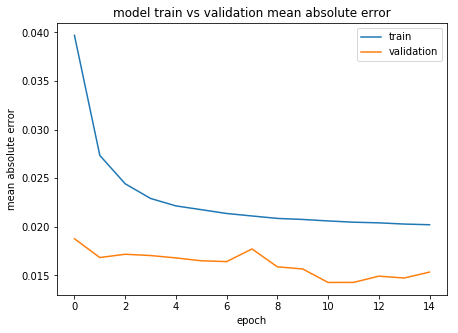

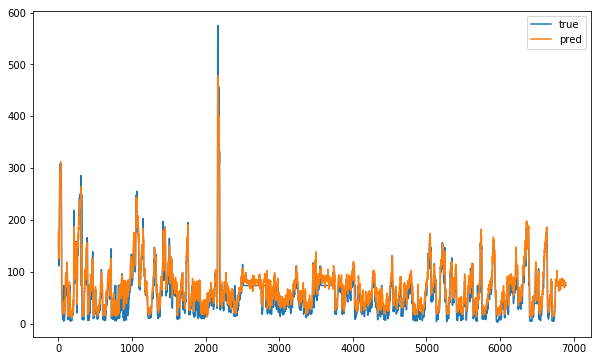

loss(test-set): 19.862132909021653
5  	6     	16.5858	0.975952	16.1709	19.4701
14 240 993
gen	nevals	avg    	std     	min    	max    
0  	10    	24.4829	12.4379 	16.4068	60.7141
1  	7     	17.8129	1.17192 	16.1709	20.1645
2  	8     	16.9806	1.26391 	16.1709	19.5415
3  	6     	18.0814	1.72364 	16.1709	22.3403
4  	6     	16.9029	1.1369  	16.1709	19.6707
5  	6     	16.5858	0.975952	16.1709	19.4701


In [18]:
runEAmuCommalambdaAlgorithm()